# Weakly-Supervised Interactive Segmentation using Max-Flow Min-Cut

### Implement interactive seed-based segmentation using s/t graph cut algorithm.

#### For the assignment of the edge weights in the graph, we first consider the hard-constraints from seeds (or "t-links") and "contrast-weights" $w_{pq}\propto \exp\frac{-\|I_p-I_q\|^2}{\sigma^2}$ as neighborhood edges (or "n-links"). Terminal "t-links" for seed-points ensure that such graph nodes can not be severed from the corresponding terminals. Therefore, we have to use "large-enough" finite cost t-links to enforce hard-constraints (user seeds) since "infinity" weight is not possible to implement. In practice, we consider $N\cdot \max \{w_{pq}\}$ (number of neighbors at each point times the largest n-link weight) is sufficient.
#### For the second part, we use seed pixels to compute color histograms $\Pr(I|1)$ and $\Pr(I|0)$ for two types of seeds (source/sink). Computing histograms requires binning (quantization) of the color space which is done via K-means over all image pixel colors (number of bins $K$ is a hyperparameter ). Then, seed-pixels histograms $\Pr(I|1)$ and $\Pr(I|0)$ based on such bins are used for unary potentials  $-\ln\Pr(I_p|1)$ and $-\ln\Pr(I_p|0)$ for all pixels $p$. The graph cut segmentation producing <font color=blue>seed-consistent</font> result $S$ minimizing the following objective (loss)
#### $$ E(S) = -\sum_p \ln\Pr(I_p|S_p) + \lambda \cdot \sum_{pq\in N} w_{pq} \cdot [S_p\neq S_q] . $$
#### Since seed-consistency is required, we still enforce hard constraints on seeds.

#### NOTE: 4-connected grid is used for the neighbourhood.

### Notes about the basic graph cut interface:

#### A basic seed-interactive GUI "GraphCutsPresenter" is implemented in "asg1.py". The starter code below uses it. Presenter allows to add seeds (left and right mouse clicks for object and background seeds) and displays these seeds over the image. The existing python library for computing minimum s/t cuts on arbitrary graphs (run "$\text{pip install PyMaxFlow}$" in Anaconda Prompt , see <a href="http://pmneila.github.io/PyMaxflow/maxflow.html">documentation</a>). This library is used to build a weighted graph based on selected image and user-entered seeds.
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.

In [23]:
import sys
!pip3 install --user PyMaxFlow
sys.path.append("/org/cs/u2/y494sun/.local/lib/python3.6/site-packages")

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import maxflow
from skimage import img_as_ubyte
from skimage.color import rgb2grey
from math import exp, log, e
# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1_error_handling import Figure, GraphCutsPresenter

In [127]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    variance = 1

    def __init__(self, img, variance=100, k=10, Lambda=10):
        self.variance = variance
        self.Lambda = Lambda
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)
        self.img = img.astype(np.int)
        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]
        # Use K-means clustering to find the histogram binning of the input images.
        KMeans_app = KMeans(img, num_clusters=k)
        self.bins = KMeans_app.compute_k_means_clusters()
        print('Bins Generation: Done!')

    def run(self):
        self.fig.show()

    def compute_labels(self, seed_mask):
        # Define source/sink seeds be subset of object/background pixels.
        src_mask = seed_mask == self.obj_value
        sink_mask = seed_mask == self.bgr_value
        
        # Compute the histgram for source/sink seed pixels using binning provided by K-means.
        self.src_hist = self.histogram(src_mask)
        self.sink_hist = self.histogram(sink_mask)
        
        # Initialize the maxflow solver by a grid of nodes with the same shape of input image.
        g = maxflow.GraphInt()
        node_ids = g.add_grid_nodes((self.num_rows, self.num_cols))
        
        # Find the regularized local contrasts in horizontal and vertical direction (4-connected grid).
        w_left = np.round(np.exp(-np.sum((self.img - np.roll(self.img, -1, axis=1)) ** 2, axis=2) / self.variance) * self.Lambda)
        w_down = np.round(np.exp(-np.sum((self.img - np.roll(self.img, -1, axis=0)) ** 2, axis=2) / self.variance) * self.Lambda)
        
        # Add n-link weights according to the regularized local contrasts in both directions.
        structure_left = np.array([[0, 0, 0], [0, 0, 1], [0, 0, 0]])
        structure_down = np.array([[0, 0, 0], [0, 0, 0], [0, 1, 0]])
        # Let each pair of nodes have the symmetric n-link weights.
        g.add_grid_edges(node_ids, weights=w_left, structure=structure_left, symmetric=True)
        g.add_grid_edges(node_ids, weights=w_down, structure=structure_down, symmetric=True)
        # Define t-link hard-constraint according to the maximum weights among all n-links.
        # Since there are four directions (4-connected grid), let the multiplier be 4.
        tedge_weight_hard = 4 * max(np.max(w_left[:-1, :-1]), np.max(w_down[:-1, :-1]))

        src_node_ids = node_ids[src_mask]
        sink_node_ids = node_ids[sink_mask]
        # Add t-link weights for source/sink seed pixels with hard-constraint.
        if src_node_ids.size != 0: g.add_grid_tedges(src_node_ids, tedge_weight_hard, 0)
        if sink_node_ids.size != 0: g.add_grid_tedges(sink_node_ids, 0, tedge_weight_hard)

        # Find optimal bin's label (0 ~ k-1) for each pixel.
        bins_distance = np.zeros((self.bins.shape[0], self.num_rows, self.num_cols))
        for bin_label, bin in enumerate(self.bins):
            bins_distance[bin_label] = np.sum((self.img - bin) ** 2, axis=2)
        bins_label_optimal = np.argmin(bins_distance, axis=0).astype(np.double)
        
        # Assign probalilities to each pixel giving its optimal bin label and source/sink histogram.
        img_prob_sink_hist = bins_label_optimal.copy()
        img_prob_src_hist = bins_label_optimal.copy()
        for key, value in self.src_hist.items():
            img_prob_src_hist[img_prob_src_hist == key] = value
        for key, value in self.sink_hist.items():
            img_prob_sink_hist[img_prob_sink_hist == key] = value
        # For zero probability, assign math.e as an identifier
        img_prob_src_hist[img_prob_src_hist == 0] = e
        img_prob_sink_hist[img_prob_sink_hist == 0] = e
        
        # Define t-link weights from source to each pixels by the neg-log likelihood to its probability in sink histogram.
        src_tedge_weight = - np.log(img_prob_sink_hist)
        sink_tedge_weight = - np.log(img_prob_src_hist)
        
        # Define t-link hard-constraint for unary potentials according to the maximum weights among all t-links.
        # Since there are only two directions (src->i and i->sink), let the multiplier be 2.
        tedge_weight_hard_hist = max(np.max(src_tedge_weight), np.max(sink_tedge_weight)) * 2
        
        # If the pixel does not belong to sink distribution, add hard-constraint weight to source node.
        src_tedge_weight[src_tedge_weight == -1] = tedge_weight_hard_hist
        sink_tedge_weight[sink_tedge_weight == -1] = tedge_weight_hard_hist
        non_seeds_mask = np.invert(np.logical_or(src_mask, sink_mask))
        # Add the t-links wights to solver for pixels that are not seed pixels.
        g.add_grid_tedges(node_ids[non_seeds_mask], src_tedge_weight[non_seeds_mask], sink_tedge_weight[non_seeds_mask])
        
        # Find segment mask (0, 1) from maxflow solver for each pixel.
        print(g.maxflow())
        segment_mask = g.get_grid_segments(node_ids)
        return np.invert(segment_mask)

    def histogram(self, mask):
        hist = {k: 0 for k in range(self.bins.shape[0])}
        seed_pixels = self.img[mask]
        for i in seed_pixels:
            bin_num = np.argmin(np.sum((self.bins - i) ** 2, axis = 1))
            hist[bin_num] += 1 / seed_pixels.shape[0]
        return hist


class KMeans:

    def __init__(self, seeds, num_clusters=2):
        self.k = num_clusters
        self.energy = np.infty
        self.im = seeds.astype(np.int)
        num_rows = self.num_rows = self.im.shape[0]
        num_cols = self.num_cols = self.im.shape[1]
        self.means = np.zeros((self.k, 3), 'd')
        self.init_means()
        self.no_label = num_clusters
        self.labels = np.full((num_rows, num_cols), fill_value=self.no_label, dtype=np.int)

    def init_means(self):
        self.energy = np.infty
        poolX = range(self.num_cols)
        poolY = range(self.num_rows)
        random_pixels = np.array([np.random.choice(poolX, self.k), np.random.choice(poolY, self.k)]).T
        for label in range(self.k):
            self.means[label] = self.im[random_pixels[label, 1], random_pixels[label, 0], :3]

    def compute_k_means_clusters(self):
        while True:
            energy = self.compute_labels()
            self.compute_means()
            num_pixels = self.num_rows * self.num_cols
            improve_per_pixel = (self.energy - energy) / num_pixels
            self.energy = energy
            if improve_per_pixel < 0.001:
                return self.means

    def compute_labels(self):
        k_dist = np.zeros((self.k, self.num_rows, self.num_cols))
        for i in range(self.k):
            k_dist[i] = np.sum((self.im - self.means[i]) ** 2, axis=2)
        opt_labels = np.argmin(k_dist, axis=0)
        min_dist = np.amin(k_dist, axis=0)
        self.labels = opt_labels
        return min_dist.sum()

    def compute_means(self):
        labels = self.labels
        for i in range(self.k):
            index = labels == i
            if np.count_nonzero(index) != 0:
                self.means[i] = np.average(self.im[index], axis=0)
            else:
                self.means[i] = np.full(3, np.infty)

### Discussion on regularization parameter Lambda:

The following 3 graph illustrates how regularization parameter Lambda affects the segmentation. Lambda is set to 10 (default) and 2. 

The segmentation becomes noisier as decrease of Lambda since the algorithm cares more about color consistency with seeds distribution. In the second graph, the noisy blue parts on the flower are less iluminated so that they are closer to the background color distribution.

On the other hand, with large enough Lambda, the segmentation is cleaner due to the higher penalty of breaking non-edge pixels. However, it might fail for object that does not have sharp edges (not shown in the graph).

<IPython.core.display.Javascript object>


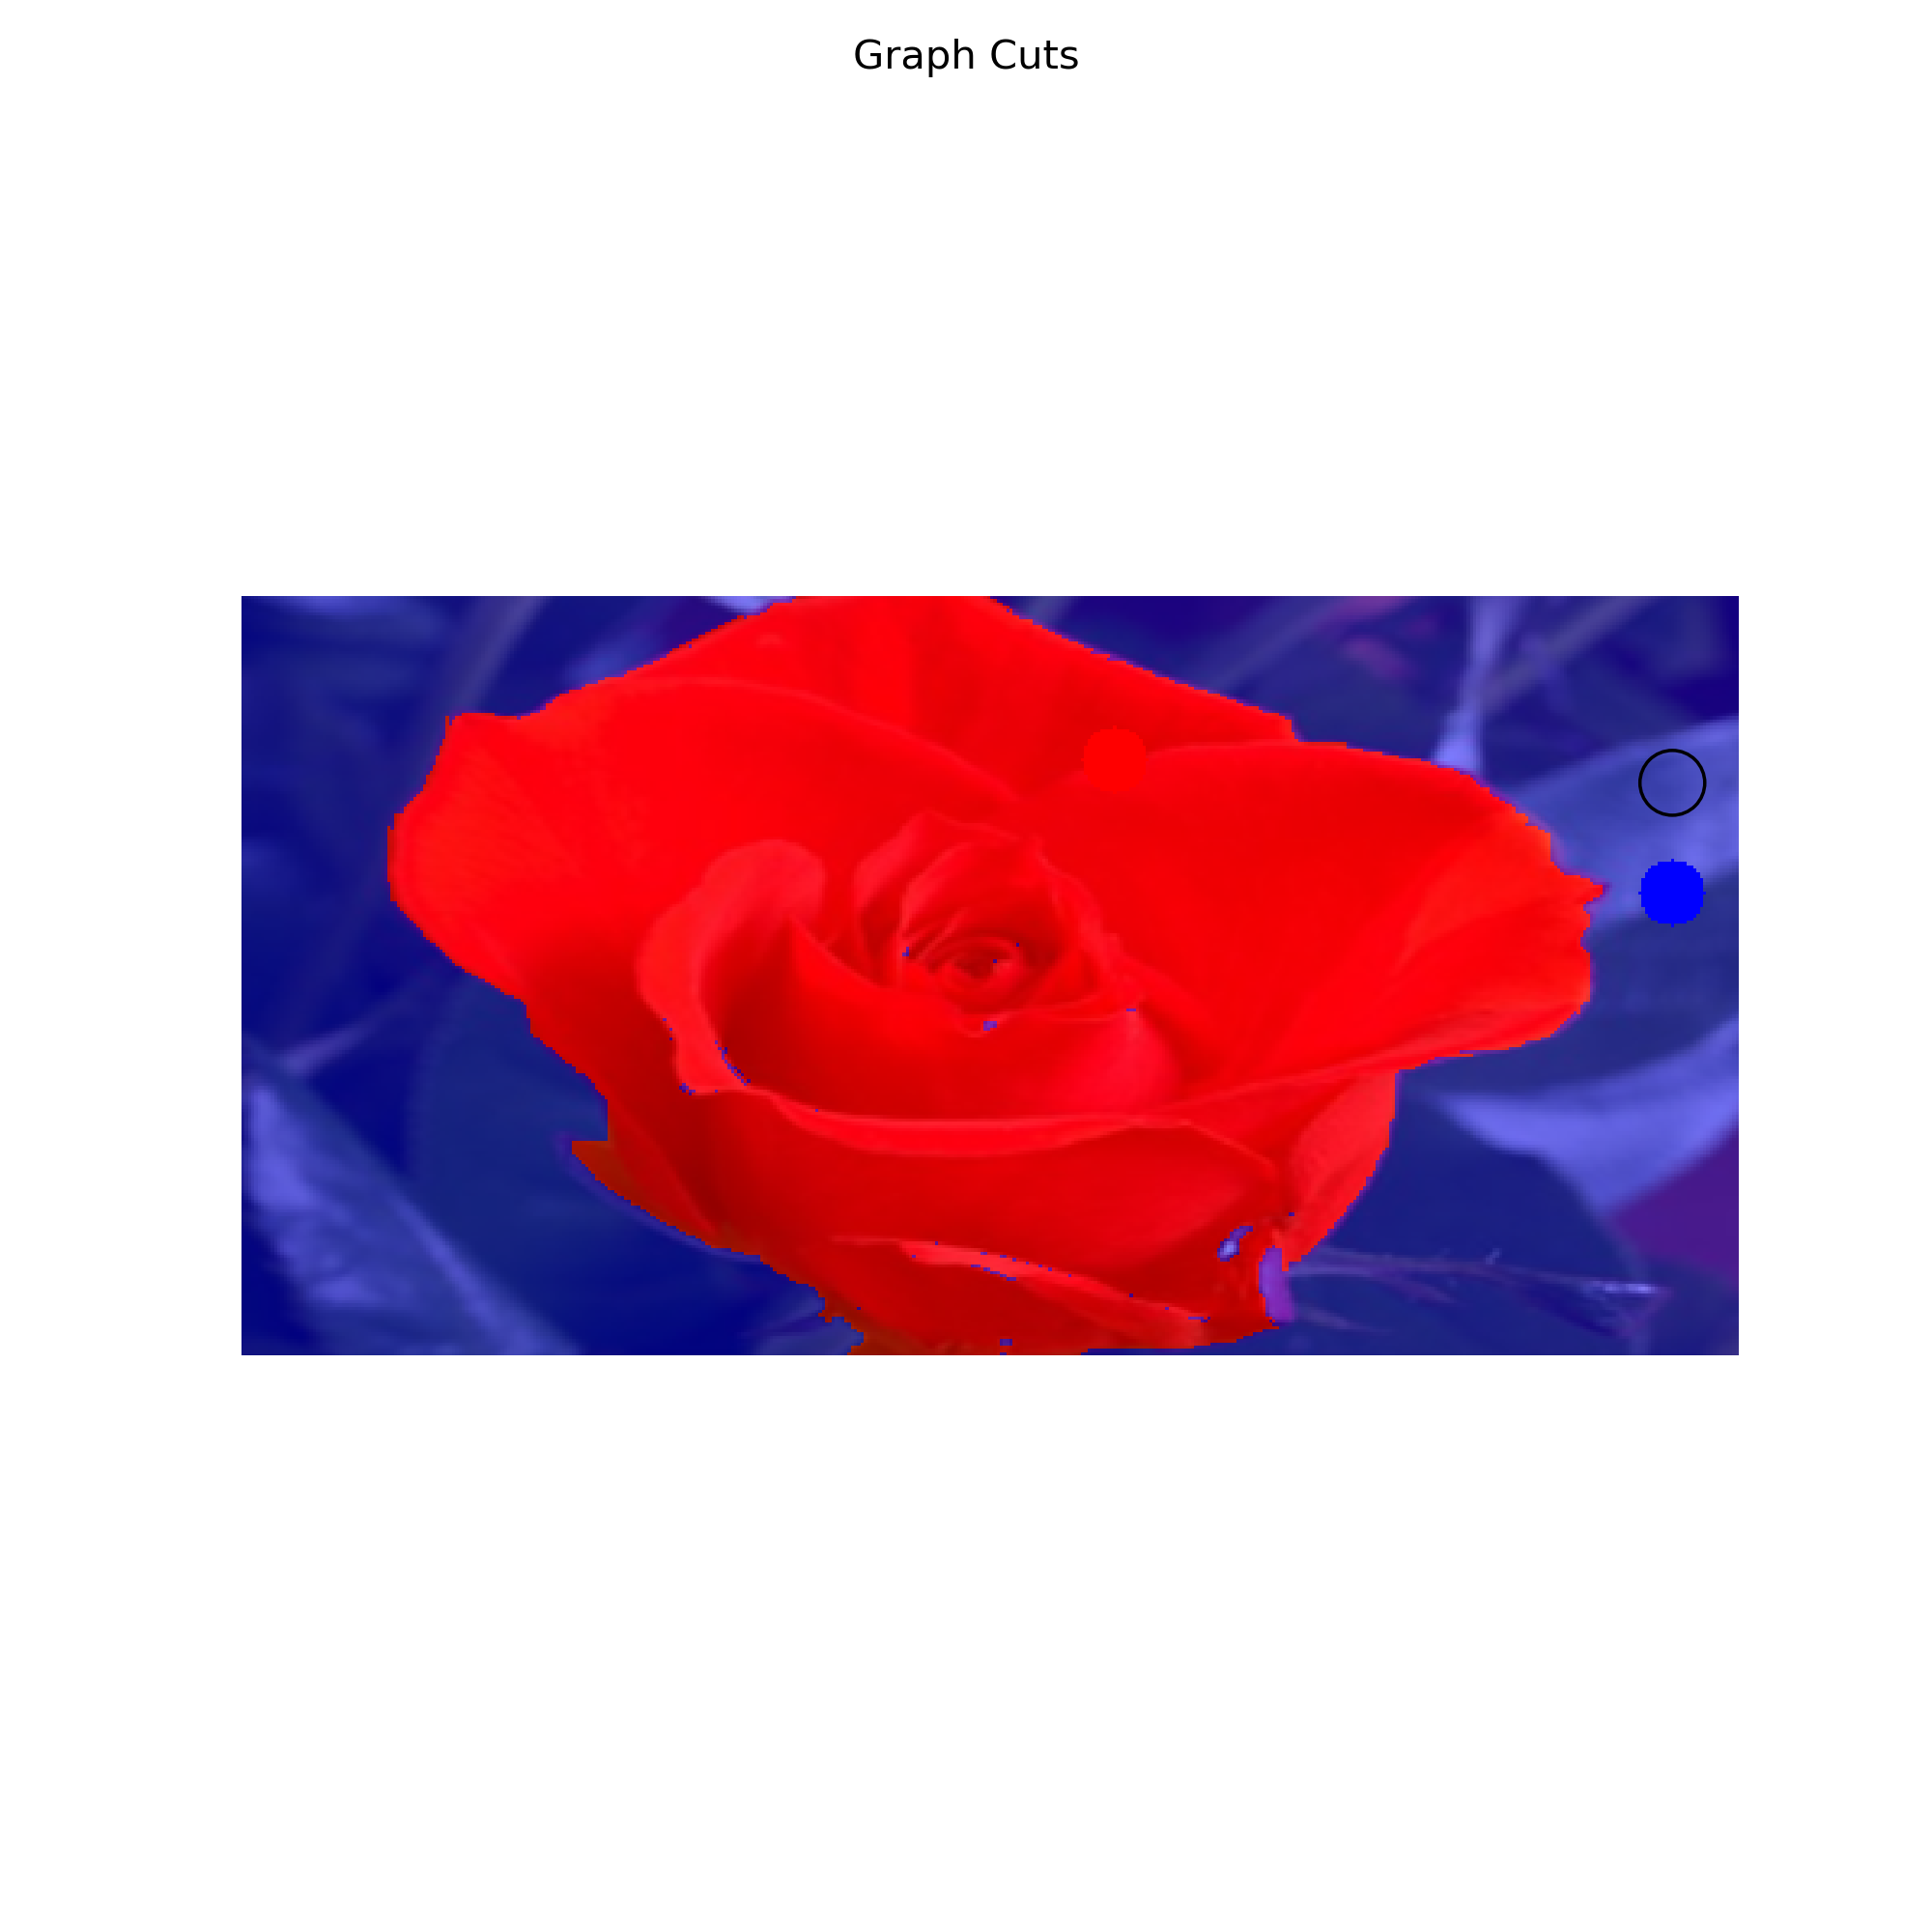

Bins Generation: Done!


In [134]:
# Base Model
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600])
app.run()

<IPython.core.display.Javascript object>


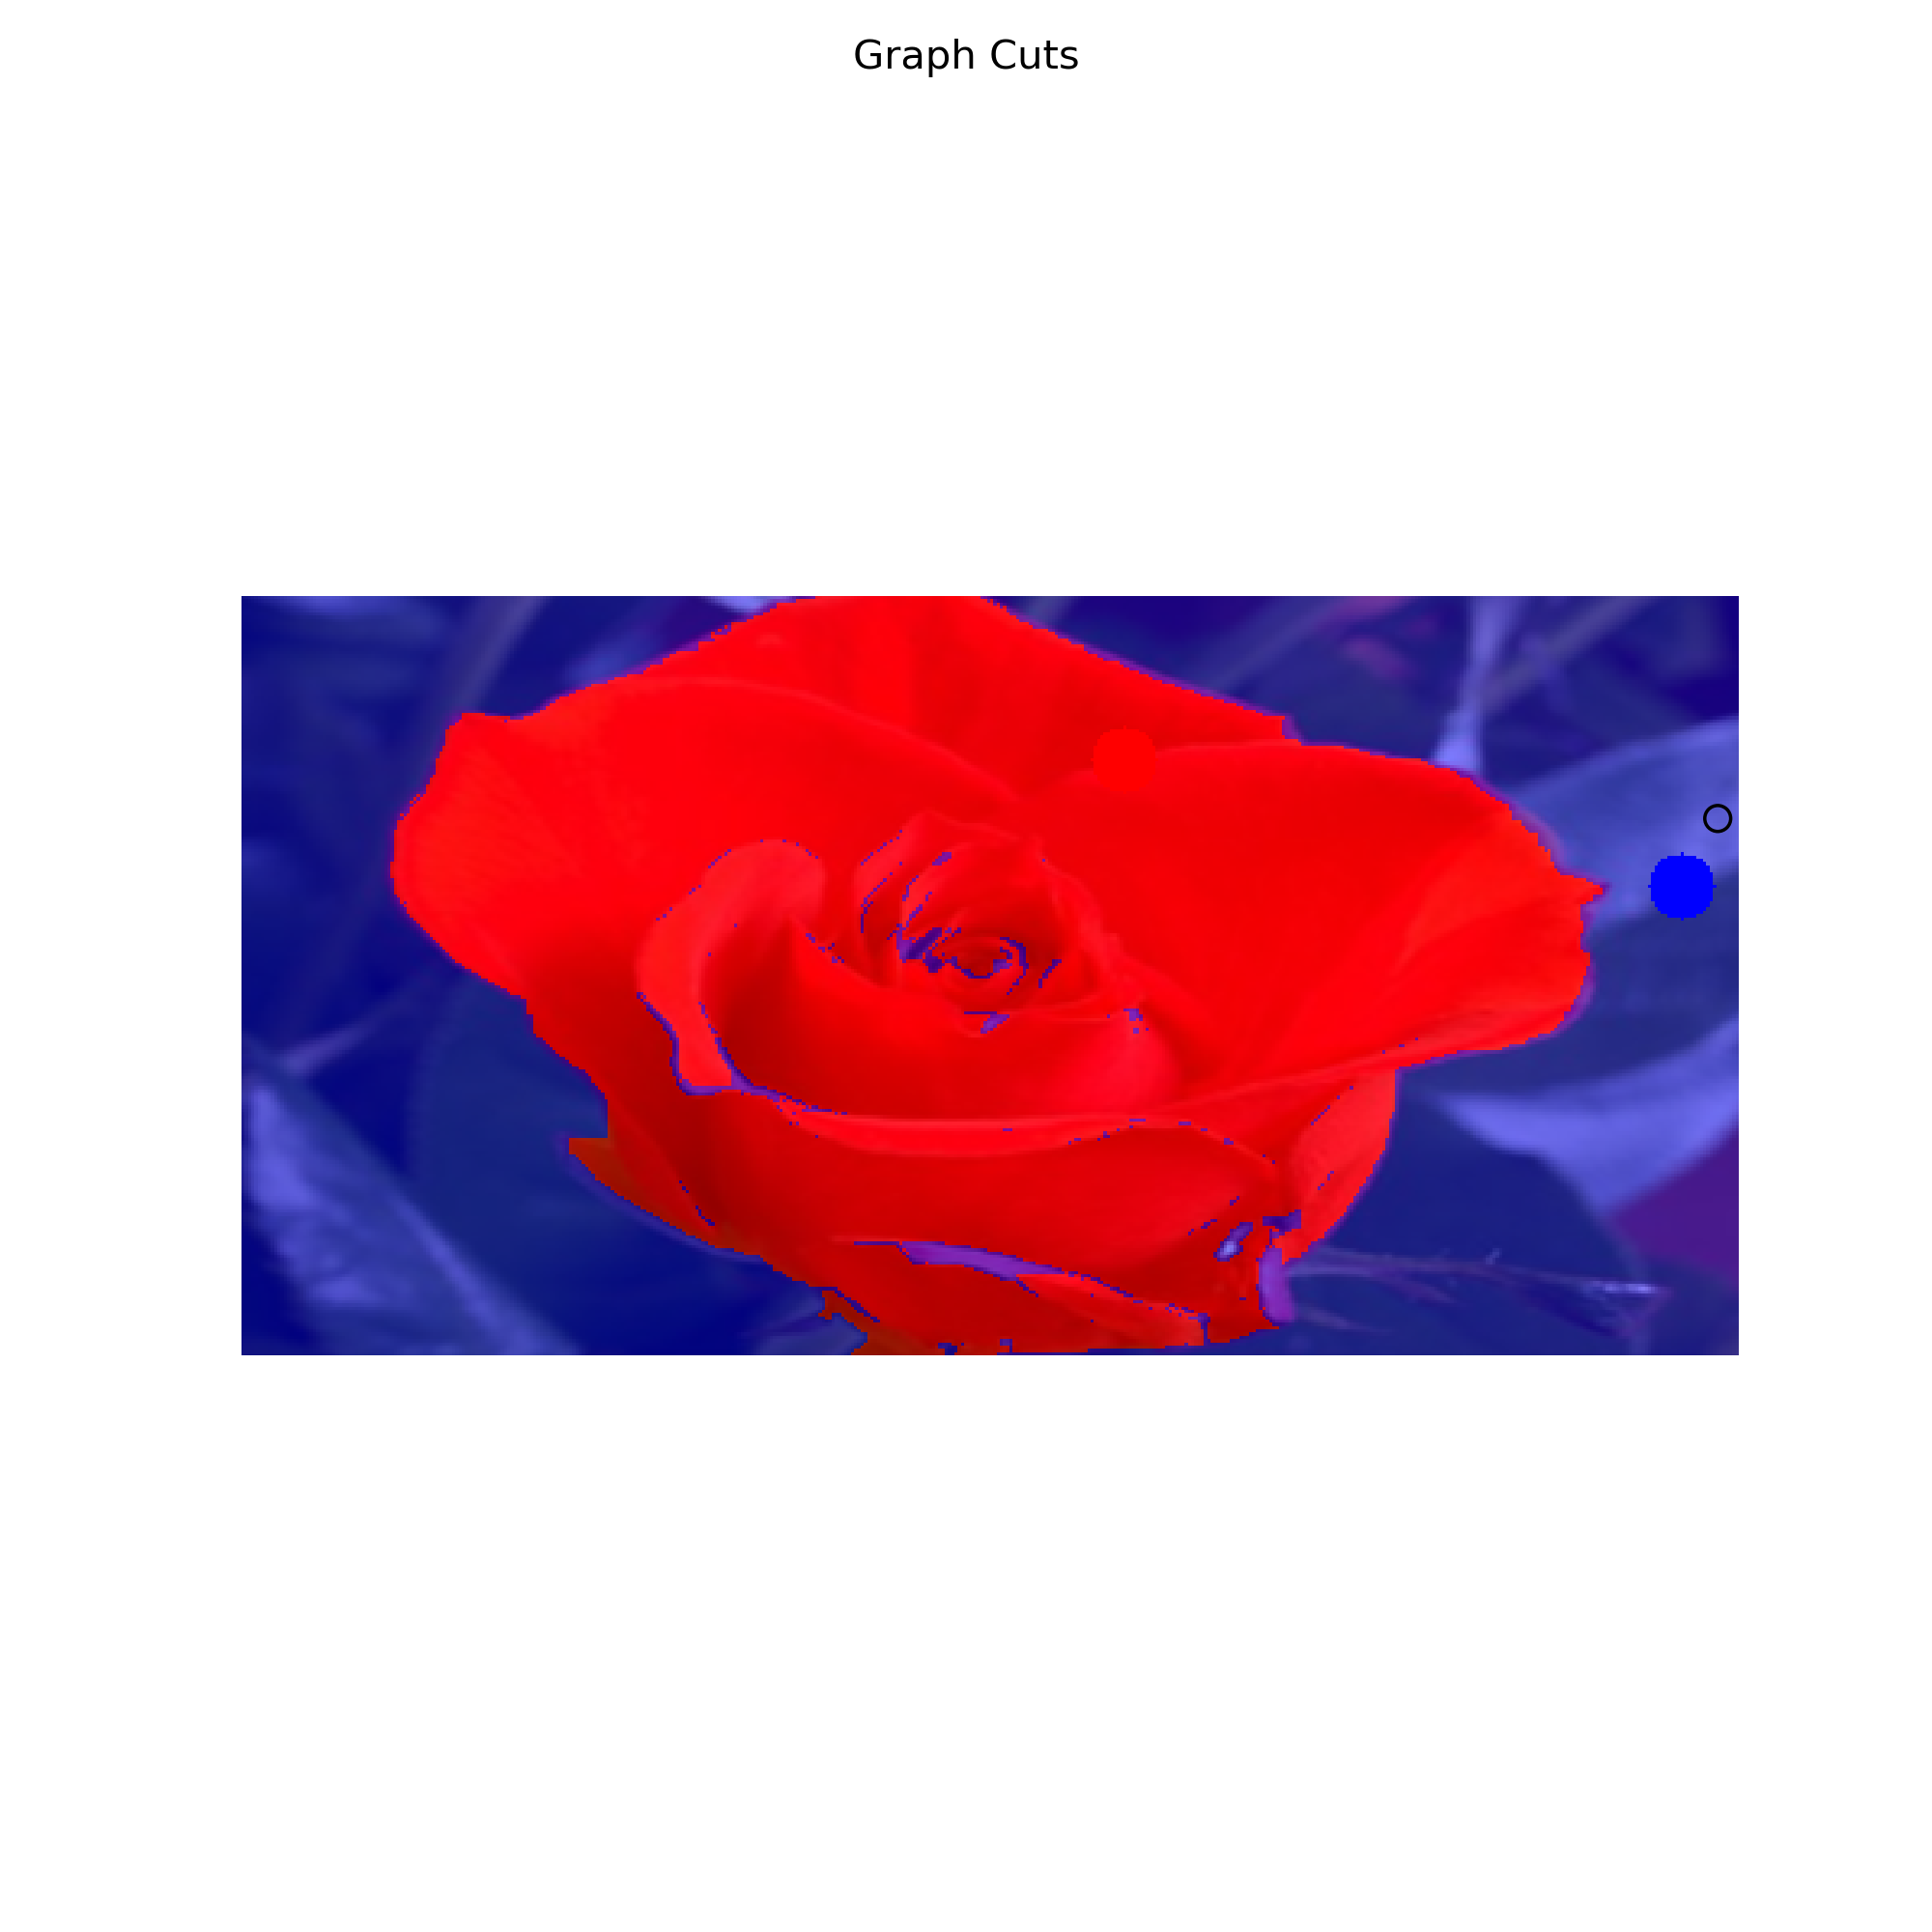

Bins Generation: Done!


In [126]:
# With small regularization parameter:
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600], Lambda=2)
app.run()

### Discussion on Gaussian variance $\sigma^2$:

When we use smaller variance, we effectively lower the threshold of penalty limit. For example, when $\sigma^2=100$, we decrease the penalty for local contrast from 0 to 10 (penalty remains almost the same for >10). After lower the $\sigma^2$ to 25, the penalty range becomes 0 to 5.

As a result, the algorithm are more sensitive to weak edges. The below graph illustrates the above points.

To adaptively choose $\sigma$ by image, we can first find all local intensity changes, then compute their mean. We may choose the computed mean as $\sigma$. The ituition is that, if the image has low-contrast, the average intensity change will be small, then choose a small $\sigma$ could detect weak edges more easily. Vice versa.

<IPython.core.display.Javascript object>


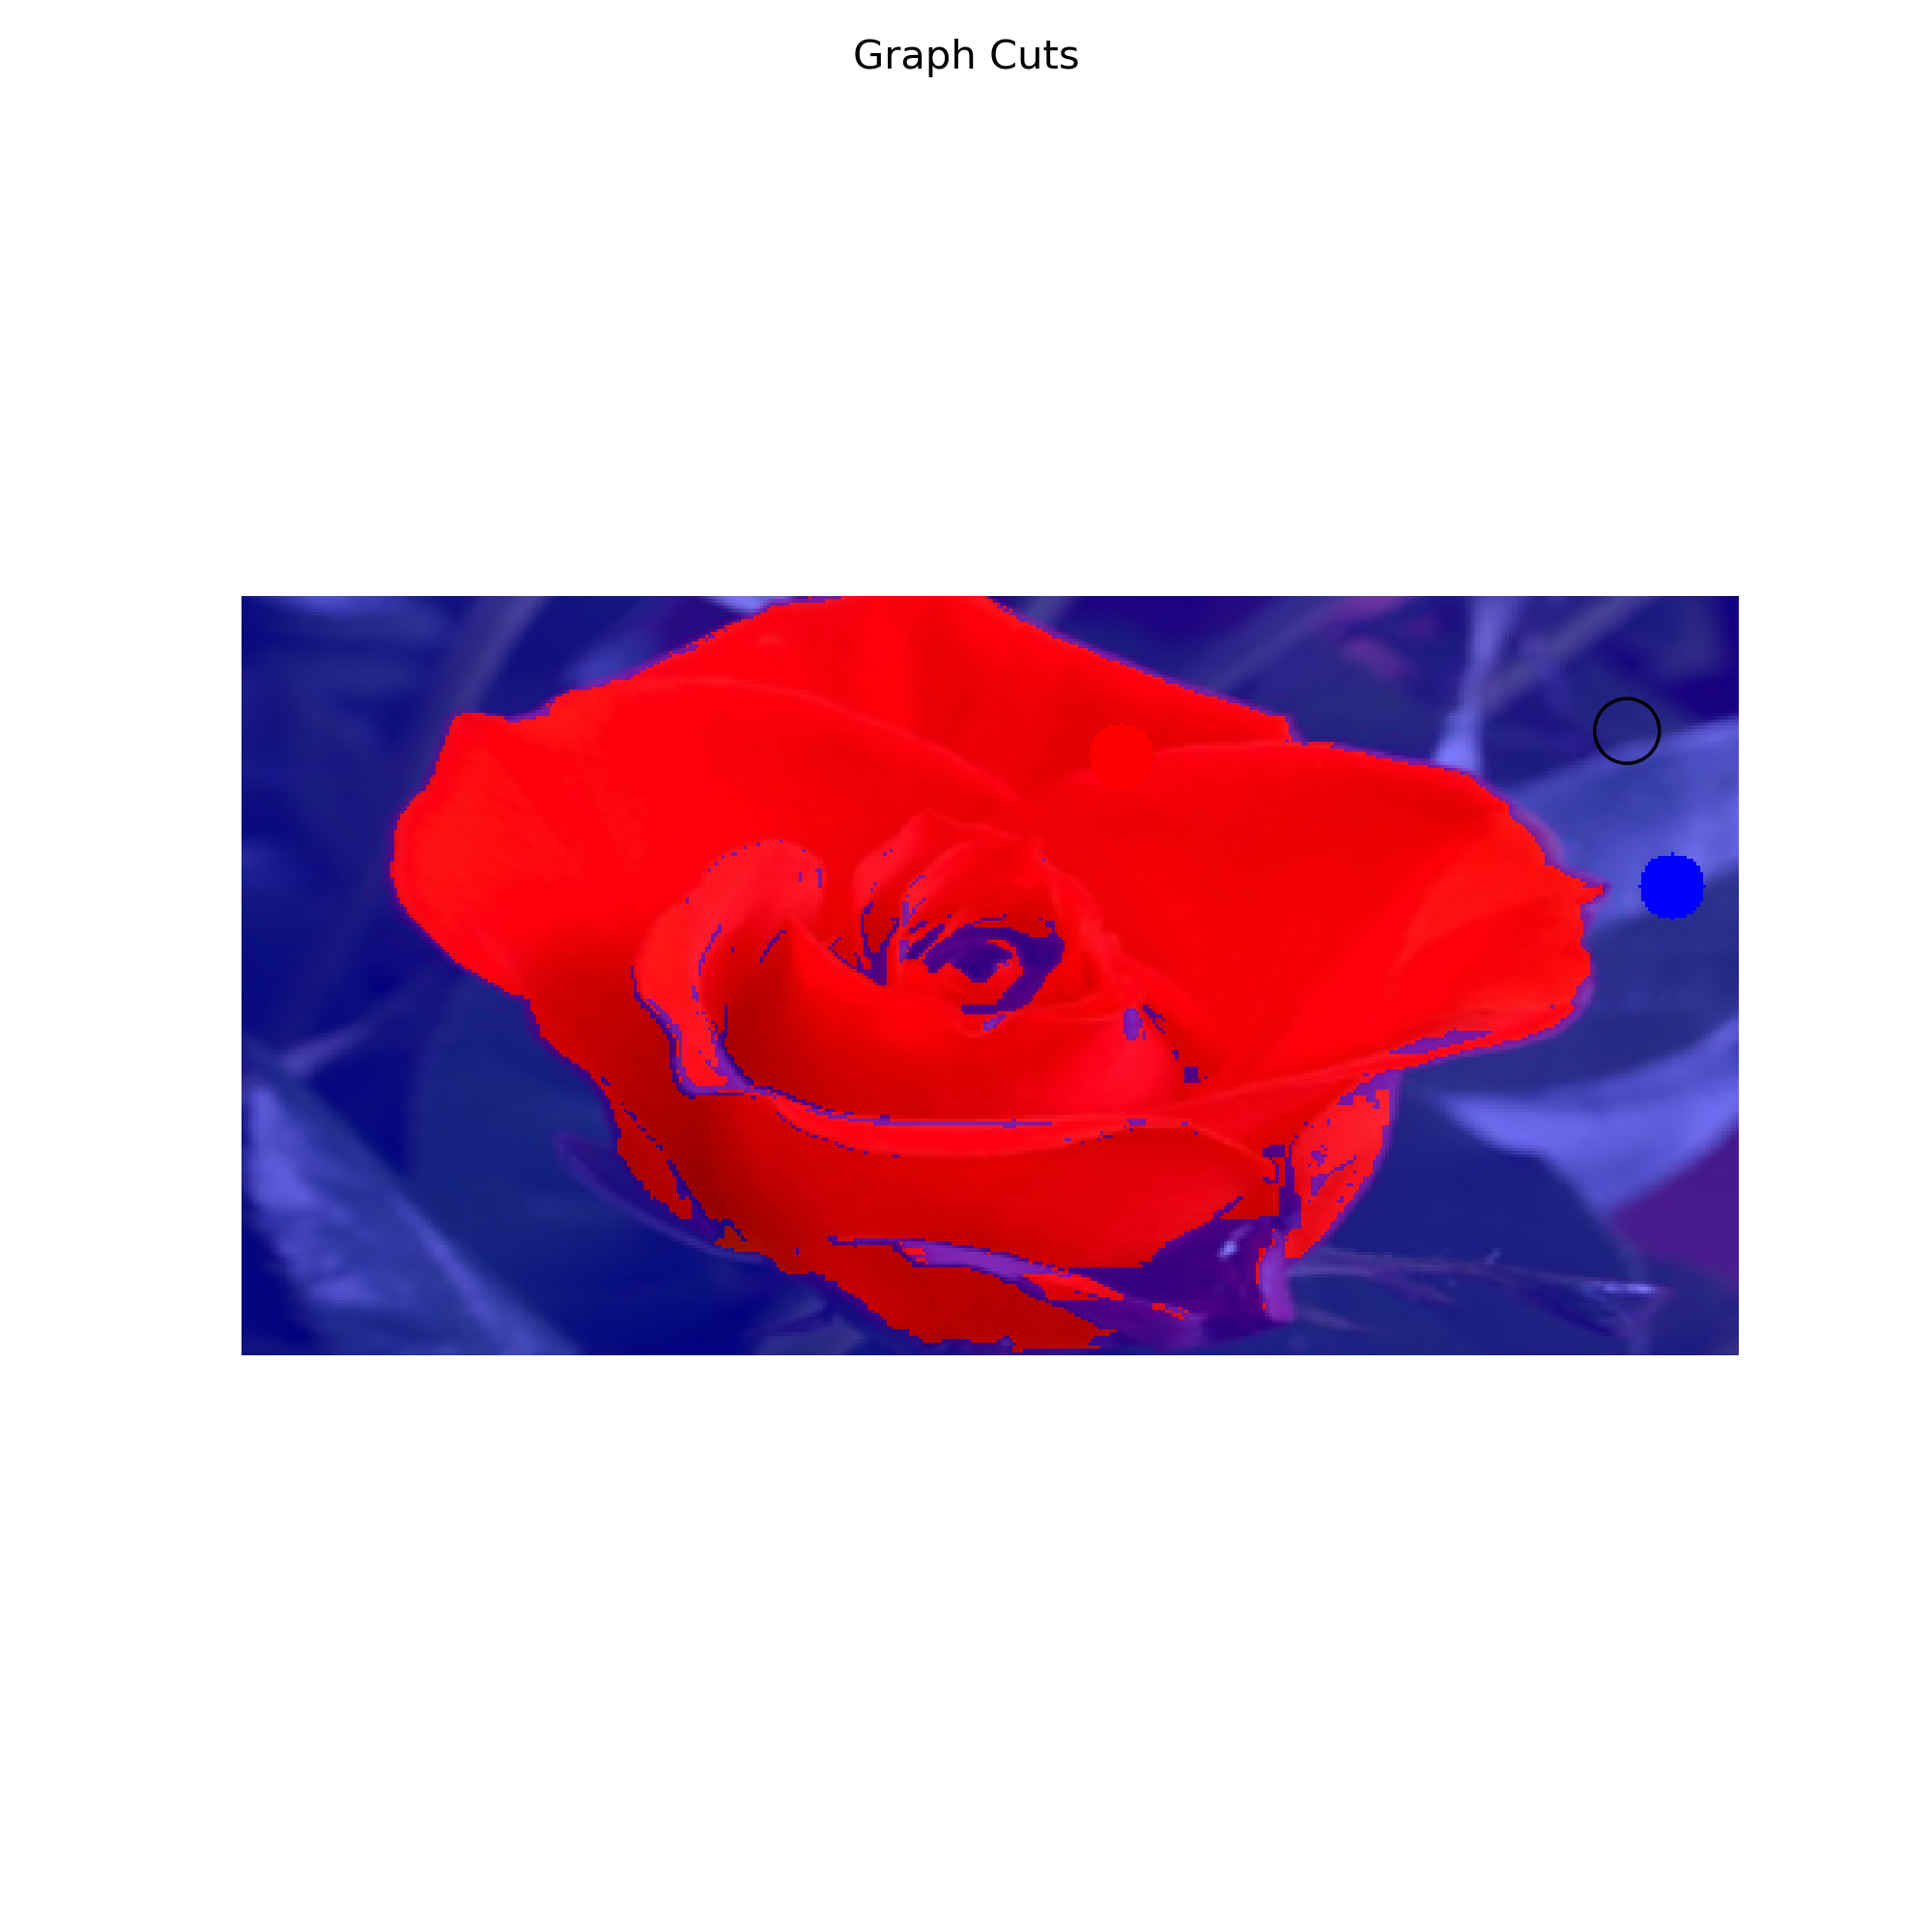

Bins Generation: Done!


In [135]:
# With samll guassian variance
img = plt.imread('images/rose.bmp')
app = MyGraphCuts(img[10:300,:600], variance=10)
app.run()

### Segmentation results for other sample images

<IPython.core.display.Javascript object>


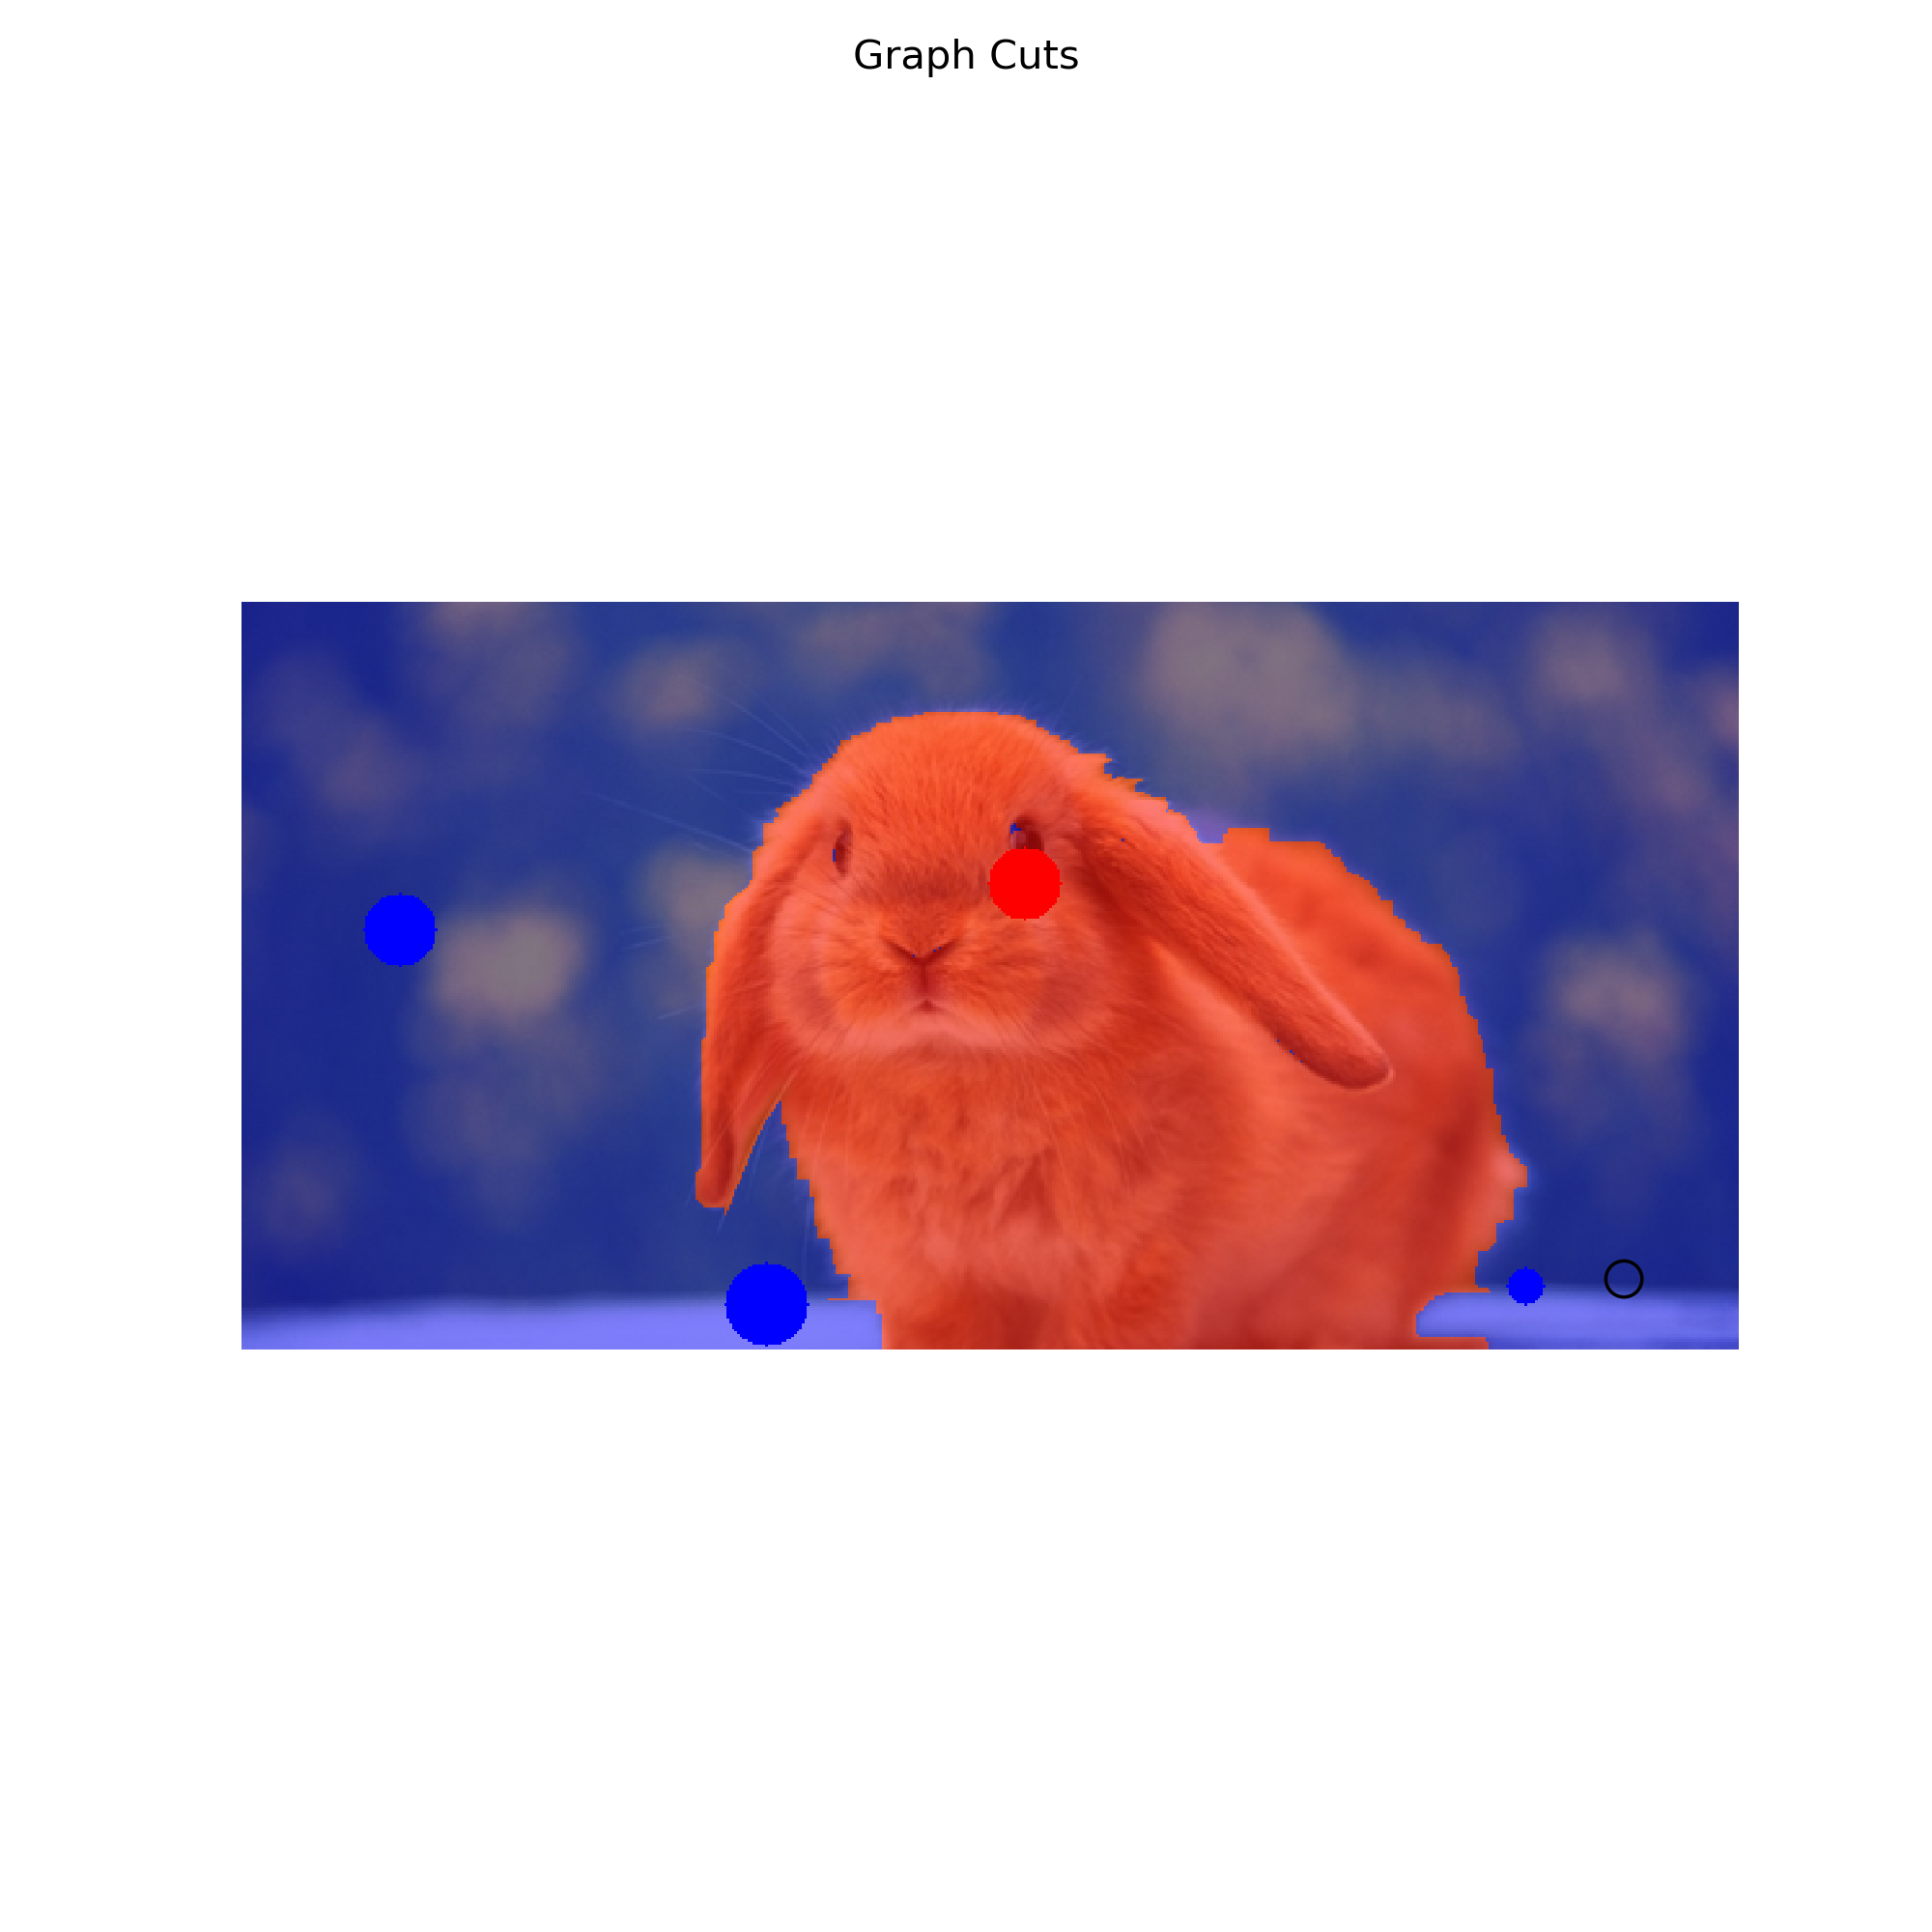

Bins Generation: Done!


In [146]:
img = plt.imread('images/bunny.bmp')
app = MyGraphCuts(img[10:300,:600], variance=200, Lambda=200)
app.run()

<IPython.core.display.Javascript object>


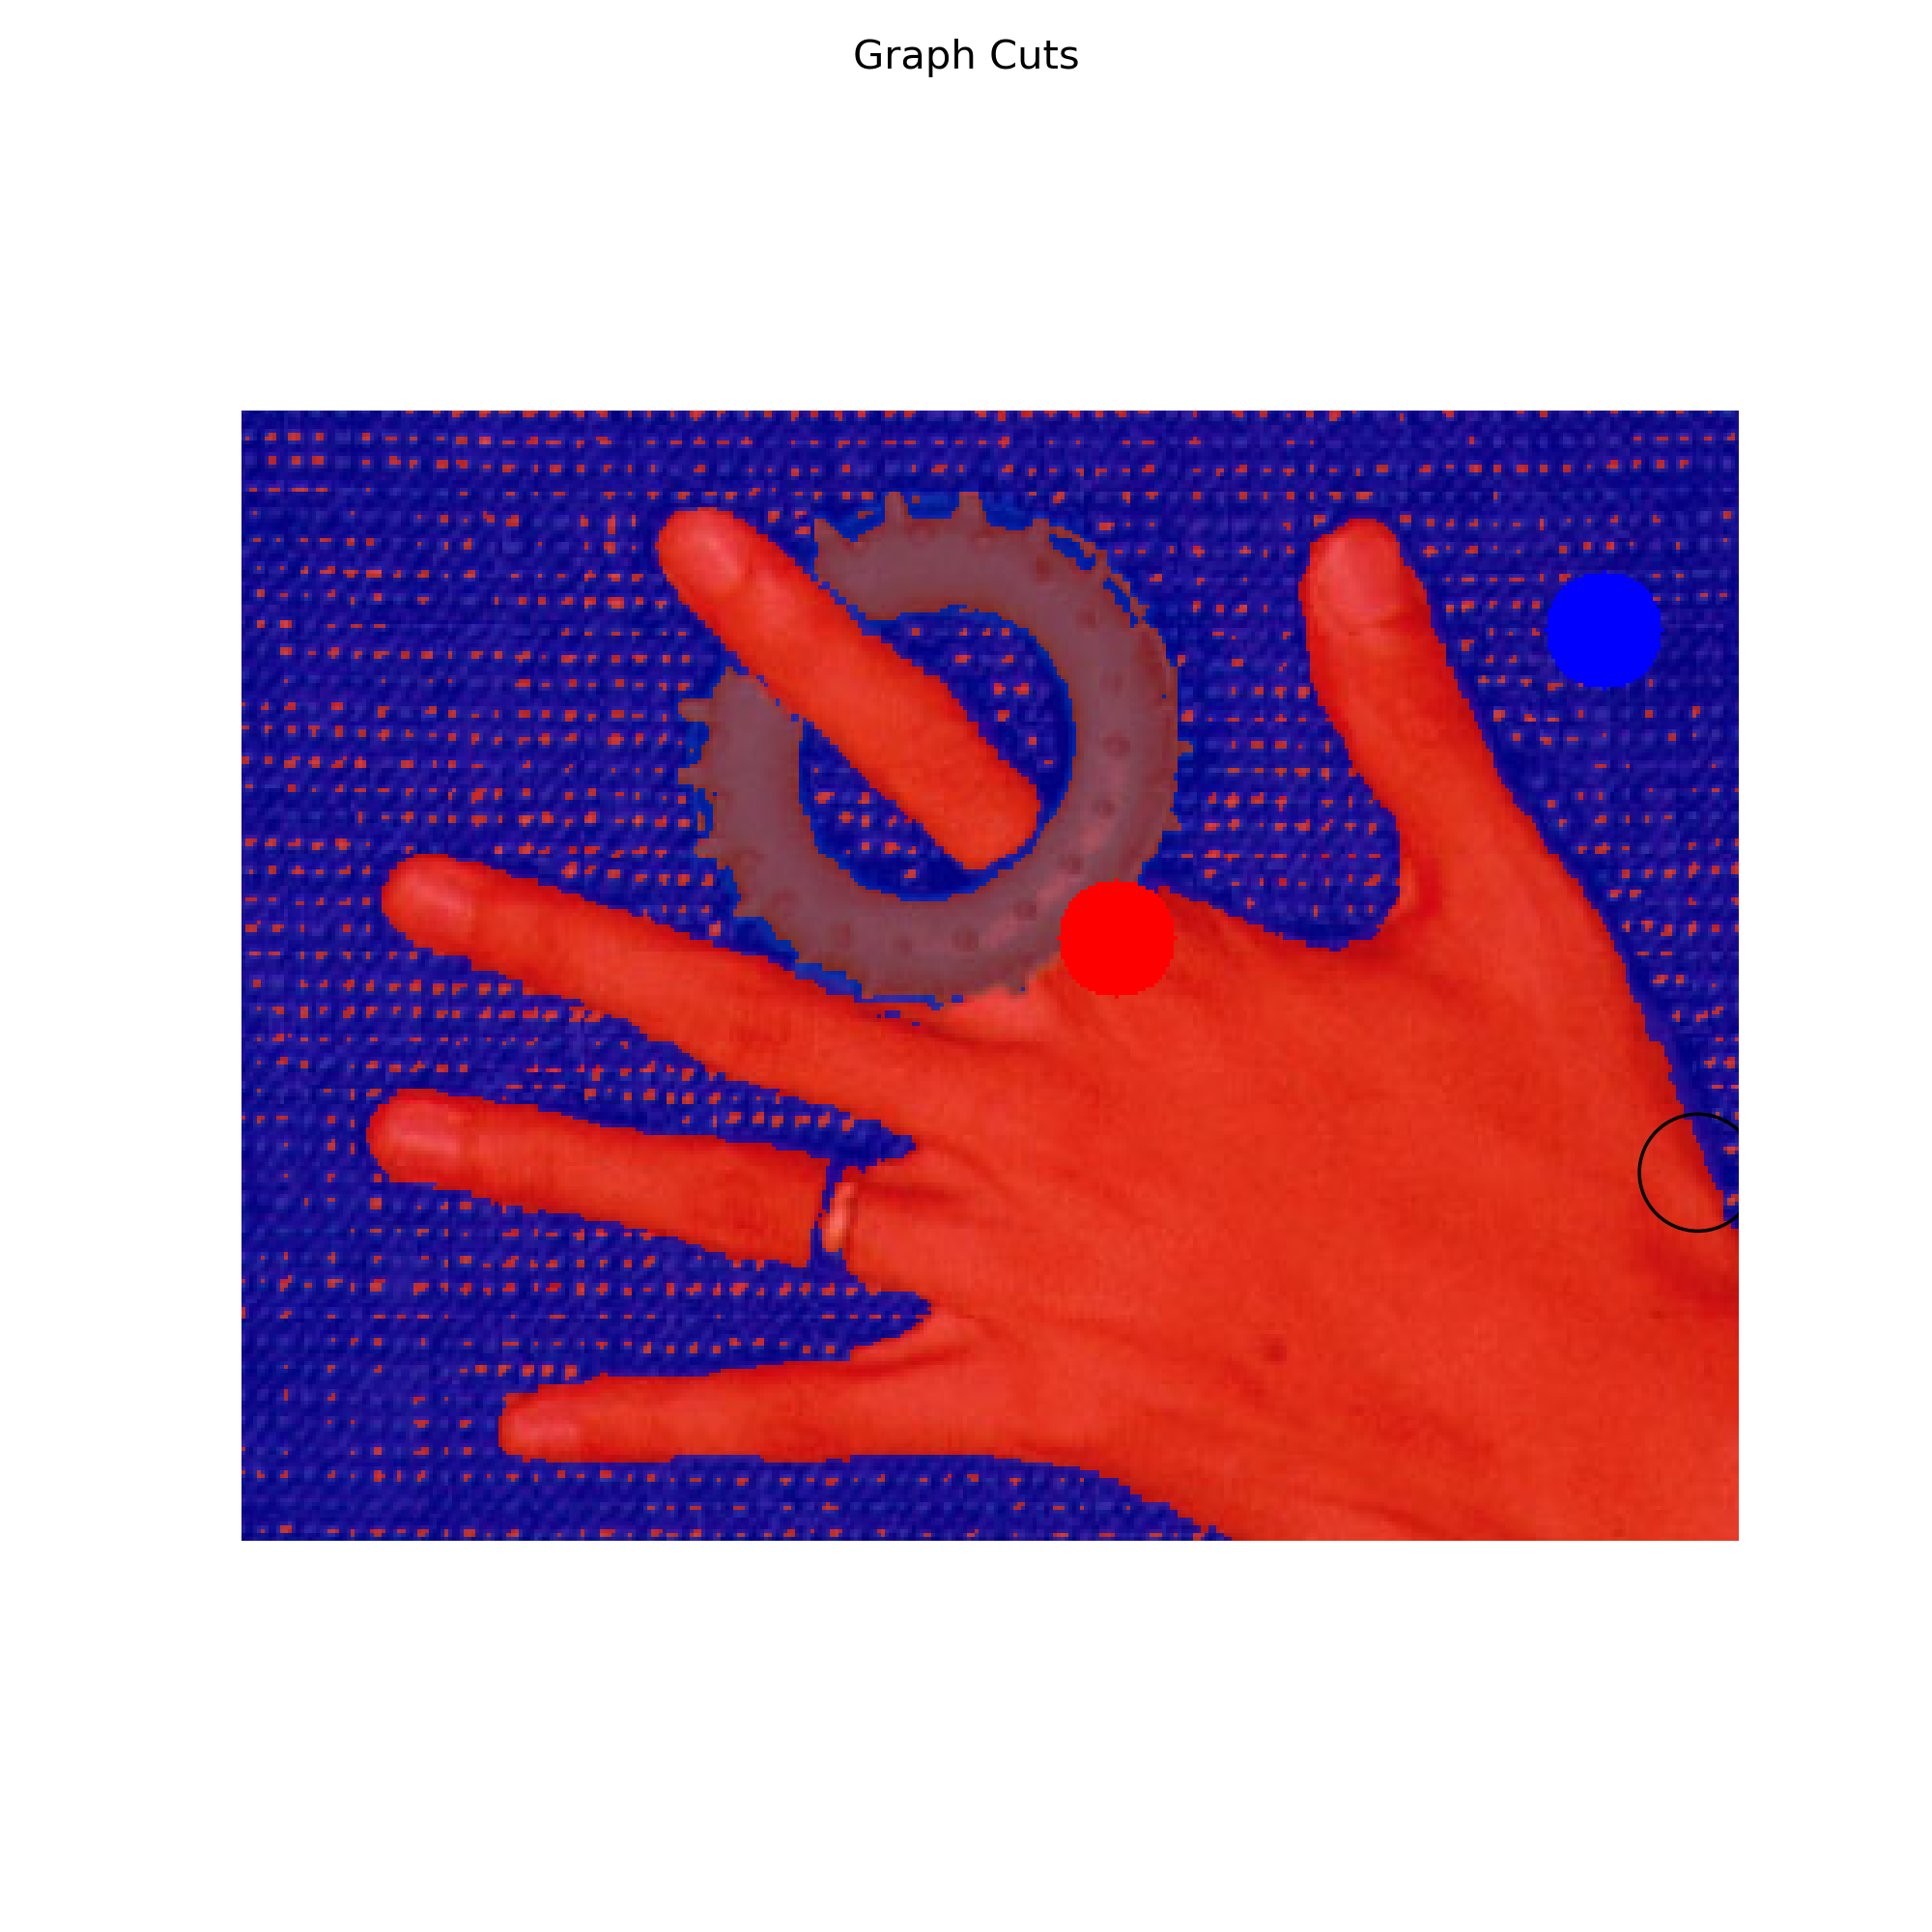

Bins Generation: Done!


In [149]:
img = plt.imread('images/hand.bmp')
app = MyGraphCuts(img[10:300,:600])
app.run()